# Explore Zenodo community

In [1]:
from zenodoExplorer.zenexp import ze

recIDs = [10835267, 10712131, 10890165]
with open("api.key", "r") as keyFile:
    ACCESS_TOKEN = keyFile.readline().rstrip()

z = ze(ACCESS_TOKEN, recIDs, cache='~/.zenodo_cache/')
z.read_zdb()
z.zdb.plot()

# Force correlations

In [2]:
z.read_dat_files('ml1@10712131')
z.read_dat_files('td2@10835267')
# Collect zip from repo
loc1 = z.get_chunk(10712131, 'TestData_MACE_IBM23_B97.zip')
loc2 = z.get_chunk(10712131, 'TestData_MACE_SD22NQ_B97.zip')

## Model trained on clusters evaluated on periodic structures vs dft

198555 198555 198555 198555


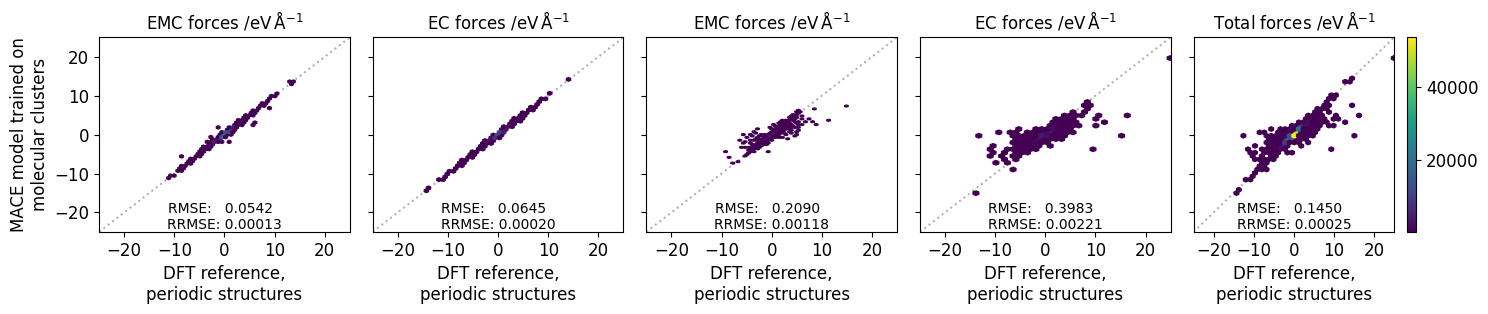

In [3]:
import copy, math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from ase.io import read, iread, write


# INDICES PERTAINING TO VOLUME SCANS IN THE DATASET
volume_scans = np.arange(757,846)

# Read data
cluster_reference = iread(loc1+'/IBM23_B97.xyz', ':')
cluster = iread(loc1+'/IBM23_mace.xyz', ':')


# ONLY WORKS FOR SORTED ATOMS-OBJECTS
def molID_counter(arr):
    """Counts the number of serial occurences of a molID in a 1-D array of 
    molID's and returns an array of counts, equal in length to the input.

    The function compares every element to the previous one. If they are the 
    same, increment the count by one and add the index to a temporary list.
    If they are not the same, create a copy of the temporary list where each
    element is equal to the total count of the last sequence and add it to
    'counts' whilst also resetting the current count.

    For example, this will result in:
    $ arr = [0,0,1,1,1,0,0,0,0]
    $ print(arr)
    [2,2,3,3,3,4,4,4,4]
    
    The last count sequence is added when the (i+1)th element cannot be
    selected."""
    counts = []
    count = 1
    for i, a in enumerate(arr):
        if i > 0:
            prev = arr[i-1]
            if a == prev:
                last_indices.append(i)
                count += 1
            else:
                counts += [count for _ in last_indices]
                last_indices = [i]
                count = 1
        else:
            last_indices = [0]

        # Adds last count array
        try:
            forward = arr[i+1]
        except:
            counts += [count for _ in last_indices]
    return counts


def unique_molID_counter(arr):
    """Counts the number of unique occurrences in a list and returns an equally
    long list where the ID has been replaced by frequency.

    Can only be applied on list objects that contain UNIQUE IDs."""
    unique_val, unique_count = np.unique(arr, return_counts=True)
    unique_map = {k:v for k,v in zip(unique_val, unique_count)}
    
    return [unique_map[a] for a in arr]


# Set y-axis limits
xy_range = [-25,25]
alpha=0.3
fsize = 12
grid_width = 20


se = {}
rse = {}
counts = {}
grid_size = (math.floor(np.sqrt(3)*grid_width), grid_width)

plt.rcParams.update({'font.size': fsize})


# DATA COLLECTION
cluster_forces, cluster_reference_forces, configs, vscan = [],[],[],[]
for i, (clst, ref) in enumerate(zip(cluster, cluster_reference)):
    cluster_forces.extend(clst.arrays['forces'].flatten())
    cluster_reference_forces.extend(ref.arrays['forces'].flatten())

    if i in volume_scans:
        vscan_bool = [1 for _ in clst.arrays['forces'].flatten()]
    else:
        vscan_bool = [0 for _ in clst.arrays['forces'].flatten()]
    vscan.extend(vscan_bool)

    cluster_config = unique_molID_counter(clst.arrays['molID'])
    configs.extend(cluster_config+cluster_config+cluster_config)

cluster_df = pd.DataFrame(
    {
        'cluster reference':cluster_reference_forces,
        'cluster forces':cluster_forces,
        'config':configs,
        'vscan':vscan,
    }
)

print(
    len(cluster_forces),
    len(cluster_reference_forces),
    len(configs),
    len(vscan)
)

# PLOTTING
fig, axs = plt.subplots(1,5, sharey=True, sharex=True, figsize=(15.15,3.3))

rmse = (np.sum((cluster_df['cluster forces']-cluster_df['cluster reference'])**2)/len(cluster_df['cluster reference']))**0.5
rrmse = rmse/(np.sum((cluster_df['cluster forces']-np.average(cluster_df['cluster forces']))**2))**0.5


#regular_structures = cluster_df[cluster_df['vscan'] == 0]
#vscans = cluster_df[cluster_df['vscan'] == 1]

#regular_ec_mace = regular_structures['cluster forces'][cluster_df['config'] == 10]
#regular_ec_dft = regular_structures['cluster reference'][cluster_df['config'] == 10]
#l = np.mean((l-k)**2)
#print(r**0.5)




axs[4].set_title(f'Total forces /eV$\,$Å$^{{-1}}$', fontsize=fsize)
lastim = axs[4].hexbin(
    cluster_df['cluster reference'],
    cluster_df['cluster forces'],
    mincnt=1,
    gridsize=grid_size,
    #norm=norm,
)
cbar = fig.colorbar(
    lastim,
    #ax=axs[4],
    #pad=0.5,
)
axs[4].annotate(
    f'RMSE:   {rmse:.4f}  \nRRMSE: {rrmse:.5f}',
    (0, xy_range[0]),
    fontsize=fsize-2,
    ha='center',
    va='bottom'
)

counts = lastim.get_array()
norm = mpl.colors.Normalize(vmin=1, vmax=max(counts), clip=False)


for ax in axs:
    ax.plot(xy_range, xy_range, 'k:', alpha=alpha, zorder=0)
    ax.set_xlim(xy_range)
    ax.set_ylim(xy_range)
    ax.set_xlabel('DFT reference,\nperiodic structures')
axs[0].set_ylabel(f'MACE model trained on\nmolecular clusters')



for vbool, vgroup in cluster_df.groupby('vscan'):
    #print('vscan:', vbool)
    for mol, cgroup in vgroup.groupby('config'):
        x = cgroup['cluster reference']
        y = cgroup['cluster forces']
        
        rmse = (np.sum((x-y)**2)/len(x))**0.5
        rrmse = rmse/(np.sum((x-np.average(x))**2))**0.5
        #print(mol, rmse, rrmse)

        if vbool == 0:
            if mol == 15:
                axs[0].set_title(f'EMC forces /eV$\,$Å$^{{-1}}$', fontsize=fsize)
                axs[0].hexbin(
                    x,
                    y,
                    mincnt=1,
                    gridsize=grid_size,
                    norm=norm,
                )
                axs[0].annotate(
                    f'RMSE:   {rmse:.4f}  \nRRMSE: {rrmse:.5f}',
                    (0, xy_range[0]),
                    fontsize=fsize-2,
                    ha='center',
                    va='bottom'
                )
            elif mol == 10:
                axs[1].set_title(f'EC forces /eV$\,$Å$^{{-1}}$', fontsize=fsize)
                axs[1].hexbin(
                    x,
                    y,
                    mincnt=1,
                    gridsize=grid_size,
                    norm=norm,
                )
                axs[1].annotate(
                    f'RMSE:   {rmse:.4f}  \nRRMSE: {rrmse:.5f}',
                    (0, xy_range[0]),
                    fontsize=fsize-2,
                    ha='center',
                    va='bottom'
                )

        else:
            if mol == 15:
                axs[2].set_title(f'EMC forces /eV$\,$Å$^{{-1}}$', fontsize=fsize)
                axs[2].hexbin(
                    x,
                    y,
                    mincnt=1,
                    gridsize=grid_size,
                    norm=norm,
                )
                axs[2].annotate(
                    f'RMSE:   {rmse:.4f}  \nRRMSE: {rrmse:.5f}',
                    (0, xy_range[0]),
                    fontsize=fsize-2,
                    ha='center',
                    va='bottom'
                )
            elif mol == 10:
                axs[3].set_title(f'EC forces /eV$\,$Å$^{{-1}}$', fontsize=fsize)
                axs[3].hexbin(
                    x,
                    y,
                    mincnt=1,
                    gridsize=grid_size,
                    norm=norm,
                )
                axs[3].annotate(
                    f'RMSE:   {rmse:.4f}  \nRRMSE: {rrmse:.5f}',
                    (0, xy_range[0]),
                    fontsize=fsize-2,
                    ha='center',
                    va='bottom'
                )


plt.tight_layout()


## Model trained on periodic structure evaluated on clusters vs dft

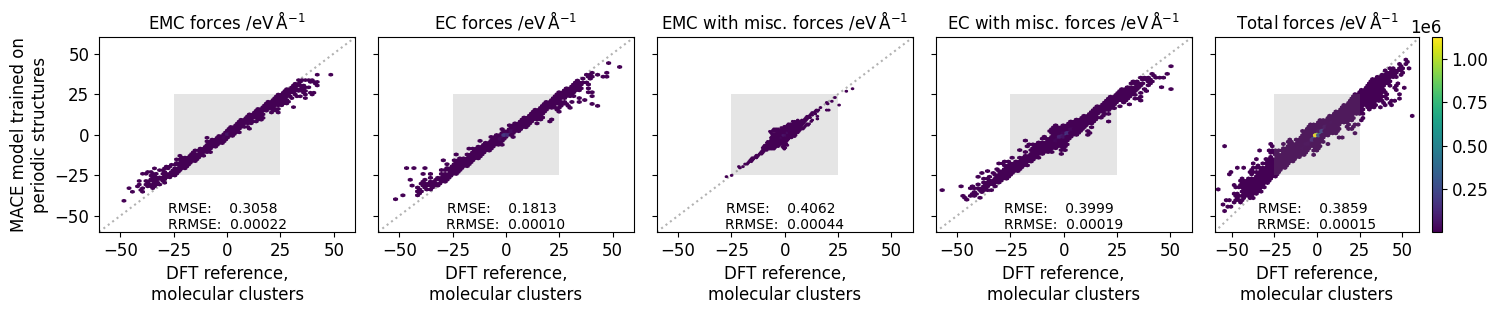

In [4]:
from matplotlib.patches import Rectangle

# Read data
periodic_reference= iread(loc2+'/SD22NQ_B97.xyz', ':')
periodic = iread(loc2+'/SD22NQ_mace.xyz', ':')


ec = 'EC forces'
emc = 'EMC forces'
with_ec = 'EC with misc. forces'
with_emc = 'EMC with misc. forces'
total = 'Total forces'
fsize = 12
grid_width = 35
xy_range = -60, 60


# DATA COLLECTION
periodic_forces, periodic_reference_forces, configs, nmols = [],[],[],[]
for per, ref in zip(periodic, periodic_reference):
    # Collect forces
    periodic_forces.extend(per.arrays['forces'].flatten())
    periodic_reference_forces.extend(ref.arrays['forces'].flatten())
    
    # Collect config types to associate with forces in a table
    ctype = ref.info['config_type']
    conf = [ctype for _ in ref.arrays['forces'].flatten()]
    configs.extend(conf)

    N = ref.info['Nmols']
    nums = [N for _ in ref.arrays['forces'].flatten()]
    nmols.extend(nums)

periodic_df = pd.DataFrame(
    {
        'periodic reference':periodic_reference_forces,
        'periodic forces':periodic_forces,
        'config_type':configs,
        'nmols':nmols
    }
)

# DATA STORAGE
se = {}
rse = {}
counts = {}
grid_size = math.ceil(np.sqrt(3)*grid_width), grid_width
dat = {'x':[], 'y':[]}
emc_dat, emc_misc_dat = copy.deepcopy(dat), copy.deepcopy(dat)
ec_dat, ec_misc_dat = copy.deepcopy(dat), copy.deepcopy(dat)



# SE DETERMINATION
group_df = periodic_df.groupby(by='config_type')
for i, grp in enumerate(group_df):
    config = grp[0]
    n = grp[1]['nmols'].iloc[0]
    x = grp[1]['periodic reference']
    y = grp[1]['periodic forces']
    
    if ':' not in config:
        # Only EMC
        if 'EMC' in config:
            # SE
            if emc not in se.keys():
                se[emc], rse[emc], counts[emc] = 0,0,0
            se[emc] += np.sum((x-y)**2)
            rse[emc] += np.sum((x-np.average(x))**2)
            counts[emc] += len(x)

            # PLOT DATA
            emc_dat['x'].extend(x); emc_dat['y'].extend(y)

        # Only EC
        if 'EC' in config:
            # SE
            if ec not in se.keys():
                se[ec], rse[ec], counts[ec] = 0,0,0
            se[ec] += np.sum((x-y)**2)
            rse[ec] += np.sum((x-np.average(x))**2)
            counts[ec] += len(x)

            # PLOT DATA
            ec_dat['x'].extend(x); ec_dat['y'].extend(y)

    else:
        # EMC + misc
        if ('EMC' in config) and ('EC' not in config):
            # SE
            if with_emc not in se.keys():
                se[with_emc], rse[with_emc], counts[with_emc] = 0,0,0
            se[with_emc] += np.sum((x-y)**2)
            rse[with_emc] += np.sum((x-np.average(x))**2)
            counts[with_emc] += len(x)

            # PLOT DATA
            emc_misc_dat['x'].extend(x); emc_misc_dat['y'].extend(y)
            
        # EC + misc
        if ('EMC' not in config) and ('EC' in config):
            # SE
            if with_ec not in se.keys():
                se[with_ec], rse[with_ec], counts[with_ec] = 0,0,0
            se[with_ec] += np.sum((x-y)**2)
            rse[with_ec] += np.sum((x-np.average(x))**2)
            counts[with_ec] += len(x)

            # PLOT DATA
            ec_misc_dat['x'].extend(x); ec_misc_dat['y'].extend(y)
            
        # Total se
        if total not in se.keys():
            se[total], rse[total], counts[total] = 0,0,0
        se[total] += np.sum((x-y)**2)
        rse[total] += np.sum((x-np.average(x))**2)
        counts[total] += len(x)


# PLOT
fig, axs = plt.subplots(1,5, sharey=True, sharex=True, figsize=(15.15,3.3))
plt.rcParams.update({'font.size': fsize})
norm = mpl.colors.Normalize(vmin=0, vmax=len(periodic_df['periodic reference']), clip=False)

auxiliary_range = [-25,25]
aux_pos = auxiliary_range[0], auxiliary_range[0]
aux_width = 2*auxiliary_range[1]

mse = {key:np.sum(val)/counts[key] for key, val in se.items()}
rrmse = {key:np.sqrt(mse[key]/val) for key, val in rse.items()}

axs[4].set_title(total+' /eV$\,$Å$^{{-1}}$', fontsize=fsize)
lastim = axs[4].hexbin(
    periodic_df['periodic reference'],
    periodic_df['periodic forces'],
    mincnt=1,
    gridsize=grid_size,
    #norm=norm,
)
cbar = fig.colorbar(
    lastim,
    ax=axs[4],
)
axs[4].annotate(
    f'RMSE:    {np.sqrt(mse[total]):.4f}  \nRRMSE:  {rrmse[total]:.5f}',
    (0, xy_range[0]),
    fontsize=fsize-2,
    ha='center',
    va='bottom'
)
counts = lastim.get_array()
norm = mpl.colors.Normalize(vmin=1, vmax=max(counts), clip=False)

for ax in axs:
    ax.plot(xy_range, xy_range, 'k:', alpha=0.3, zorder=0)
    ax.set_xlim(xy_range)
    ax.set_ylim(xy_range)
    ax.set_xlabel('DFT reference,\nmolecular clusters')
    ax.add_patch(
        Rectangle(
            aux_pos,
            aux_width,
            aux_width,
            facecolor='gray',
            alpha=0.2,
        )
    )
axs[0].set_ylabel('MACE model trained on\nperiodic structures')

axs[0].set_title(emc+' /eV$\,$Å$^{{-1}}$', fontsize=fsize)
axs[0].hexbin(
    emc_dat['x'],
    emc_dat['y'],
    mincnt=1,
    gridsize=grid_size,
    norm=norm,
)
axs[0].annotate(
    f'RMSE:    {np.sqrt(mse[emc]):.4f}  \nRRMSE:  {rrmse[emc]:.5f}',
    (0, xy_range[0]),
    fontsize=fsize-2,
    ha='center',
    va='bottom'
)

axs[1].set_title(ec+' /eV$\,$Å$^{{-1}}$', fontsize=fsize)
axs[1].hexbin(
    ec_dat['x'],
    ec_dat['y'],
    mincnt=1,
    gridsize=grid_size,
    norm=norm,
)
axs[1].annotate(
    f'RMSE:    {np.sqrt(mse[ec]):.4f}  \nRRMSE:  {rrmse[ec]:.5f}',
    (0, xy_range[0]),
    fontsize=fsize-2,
    ha='center',
    va='bottom'
)

axs[2].set_title(with_emc+' /eV$\,$Å$^{{-1}}$', fontsize=fsize)
axs[2].hexbin(
    emc_misc_dat['x'],
    emc_misc_dat['y'],
    mincnt=1,
    gridsize=grid_size,
    norm=norm,
)
axs[2].annotate(
    f'RMSE:    {np.sqrt(mse[with_emc]):.4f}  \nRRMSE:  {rrmse[with_emc]:.5f}',
    (0, xy_range[0]),
    fontsize=fsize-2,
    ha='center',
    va='bottom'
)

axs[3].set_title(with_ec+' /eV$\,$Å$^{{-1}}$', fontsize=fsize)
axs[3].hexbin(
    ec_misc_dat['x'],
    ec_misc_dat['y'],
    mincnt=1,
    gridsize=grid_size,
    norm=norm,
)
axs[3].annotate(
    f'RMSE:    {np.sqrt(mse[with_ec]):.4f}  \nRRMSE:  {rrmse[with_ec]:.5f}',
    (0, xy_range[0]),
    fontsize=fsize-2,
    ha='center',
    va='bottom'
)


plt.tight_layout()